In [1]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import random
import threading
import math

import subprocess
import sys
GITPATH = subprocess.run('git rev-parse --show-toplevel'.split(' '), \
        stdout=subprocess.PIPE).stdout.decode('utf-8').replace('\n','')
sys.path.append(GITPATH)
import dobroEnv

/home/wooseoko/anaconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
#hyper parameters
t_max = 1
gamma = 0.95
learning_rate = 0.001
beta = 0.1

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)


In [3]:
env = gym.make('DobroHalfCheetah-v0')
env.unwrapped.initialize(is_render=False)
print(env.action_space.sample())

[-0.93884313  0.5630308   0.24319178 -0.30374    -0.22571829 -0.28242505]


In [4]:
class policy_net(nn.Module):
    def __init__(self, input_feature , num_actions):
        super(policy_net,self).__init__()
        self.linear1 = nn.Linear(in_features = input_feature, out_features = 128)
        self.activation1 = nn.ReLU()
        self.linear = nn.Linear(in_features = 128, out_features = 256)
        self.activation2 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = 256, out_features = num_actions)
        #self.linear3 = nn.Linear(in_features = 256, out_features = num_actions)
        self.mean_act = nn.Tanh()
        

        
    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.activation2(self.linear(x))
        mean = self.mean_act(self.linear2(x))
        #variance = self.var_act(self.linear3(x)) + 0.0001
        variance = torch.Tensor([0.25])
        return mean , variance
    
class value_net(nn.Module):
    def __init__(self, input_feature):
        super(value_net,self).__init__()
        self.linear1 = nn.Linear(in_features = input_feature, out_features = 128)
        self.activation1 = nn.ReLU()
        self.linear = nn.Linear(in_features = 128, out_features = 256)
        self.activation2 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = 256, out_features = 1)

        
    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.activation2(self.linear(x))
        x = self.linear2(x)
        return x
    
    
    

In [1]:

def get_action(mean , variance, num_actions):
    action = [np.random.normal(mean[i].detach().numpy(), variance[i].detach().numpy(), 1).item() for i in range(num_actions) ]
    true_action = []
    for i in range(len(mean)):
        for j in range(10000):
            action = np.random.normal(mean[i].detach(), variance[i].detach(), 1).item()
            if(action >= -1 and action <=1):
                true_action.append(action)
        if( len(true_action) <= i):
            true_actioin.append(mean[i])
    return true_action



In [7]:
#multihtread
num_actions = 6
p_net_shared = policy_net(20,num_actions)
v_net_shared = value_net(20)
np.random.seed(seed)
torch.manual_seed(seed)
_lock = threading.Lock()

reward_plot = [0 for i in range(5000)]

def training(idx):
    t_max = 5
    gamma = 0.99
    learning_rate = 0.001
    beta = 0
    step = 0
    state = []
    


    global p_net_shared
    global v_net_shared
    p_optimizer = optim.Adam(p_net_shared.parameters(), lr=0.0001)
    v_optimizer = optim.Adam(v_net_shared.parameters(), lr=0.001)
    global reward_plot
    
    for iteration in range(5000):
        done = False
        env = gym.make('DobroHalfCheetah-v0')
        env.unwrapped.initialize(is_render=False)
        observation = env.reset()
        state = observation
        
        p_net = policy_net(20,num_actions)
        v_net = value_net(20)
    
        p_net.zero_grad()
        v_net.zero_grad()
        
        t_update = 0
        #beta -= 0.0002
        #learning_rate -= 0.0009/2000
        if(beta<=0):
            beta = 0
        reward_stack = []
        prob_stack = []
        value_stack = []
        action_stack = []
        entropy = 0
        reward_sum = 0
        policy_loss_sum=0
        value_loss_sum = 0
        entropy_sum = 0
        
        
        mean_average = np.zeros(num_actions)
        variance_average = np.zeros(num_actions)
        
        
        for t in range(10000):

            step = step+1

            mean, variance= p_net(torch.Tensor(state))
            value = v_net(torch.Tensor(state))            
            
            mean_average += mean.detach().numpy()
            variance_average += variance.detach().numpy()
            
            action = get_action(mean,variance,num_actions)
            
            next_state , reward, done, info = env.step(action)
            #reward /= 16.2736044
            reward_sum += reward
            t_update += 1

            reward_stack.append(reward)
            value_stack.append(value)
            prob_stack.append((mean,variance))
            action_stack.append(action)
            
            for i in range(num_actions):
                entropy += -(torch.log(torch.clamp(2*math.pi*variance[i]*variance[i] , min = 1e-6)) + 1)/2

            if(t_update >= t_max or done):
                if(done):
                    R=0
                else:
                    R = v_net(torch.Tensor(next_state))
                policy_loss = 0
                value_loss = 0
                

                for i in range(t_update):
                    R = R*gamma + reward_stack.pop()
                    value_temp = value_stack.pop()
                    mu , var = prob_stack.pop()
                    action_i = action_stack.pop()
                    advantage = (R-value_temp).detach()
                    for j in range(num_actions):
                        policy_loss += ( (( (action_i[j] - mu[j]) )**2)/2 ) * advantage
                    value_loss += (R-value_temp) * (R-value_temp)

                entropy_sum += entropy / t_max
                entropy = -entropy * beta
                policy_loss = policy_loss + entropy 
                policy_loss = policy_loss / t_max
                value_loss = value_loss /t_max

                _lock.acquire()
                
                policy_loss.backward(retain_graph=True)
                value_loss.backward()
                policy_loss_sum += policy_loss.detach().numpy()
                value_loss_sum += value_loss.detach().numpy()
                
                for p_param , s_p_param in zip(p_net.parameters(), p_net_shared.parameters()):
                    s_p_param._grad = p_param.grad.detach()
                    if((s_p_param != s_p_param).any()):
                        print("explode !!!! ")
                        
                        
                for v_param , s_v_param in zip(v_net.parameters(), v_net_shared.parameters()):
                    s_v_param._grad = v_param.grad.detach()
                    if((s_v_param != s_v_param).any()):
                        print("explode !!!! ")
                
                p_optimizer.step()
                v_optimizer.step()
                p_net_shared.zero_grad()
                v_net_shared.zero_grad()

                _lock.release()
                
                
                
                p_net = policy_net(20,num_actions)
                v_net = value_net(20)    

                p_net.load_state_dict(p_net_shared.state_dict())
                v_net.load_state_dict(v_net_shared.state_dict())
                R=0
                entropy = 0
                t_update = 0
            if(done):
                mean_average /= t + 1
                variance_average /= t+1
                break

            #env.render()
            state = next_state[:]
        reward_plot[iteration] += reward_sum
        env.close()
        if(iteration%10 ==0):
            print(p_net_shared.variance_lin.bias)
            print(policy_loss_sum)
            print(value_loss_sum)
            print(entropy_sum)
            print("mean_average : {}".format(mean_average))
            print("variance_average : {}".format(variance_average))
            print("training idx {} actor true_reward at iteration {} : {}".format(idx,iteration, reward_sum))
            print(step)
            beta = beta * 0.99
th1 = threading.Thread(target = training , args = (1,))
'''th2 = threading.Thread(target = training , args = (2,))
th3 = threading.Thread(target = training , args = (3,))
''''''th4 = threading.Thread(target = training , args = (4,))'''
th1.start()
'''th2.start()
th3.start()
''''''th4.start()'''

th1.join()
'''th2.join()
th3.join()
''''''th4.join()'''

print("finish")

Parameter containing:
tensor([ 0.4869,  0.8546,  0.3070,  0.3286, -0.9944,  0.3277],
       requires_grad=True)
[-94.92982]
[196.18166]
tensor(-354.2885, grad_fn=<AddBackward0>)
mean_average : [ 3.74401013e-04  1.57313219e-01 -5.81552007e-01 -3.80996105e-01
 -9.74862147e-02 -2.56028673e-01]
variance_average : [1.30906618 0.76434    0.93892009 0.74878972 0.23234996 0.88940783]
training idx 1 actor true_reward at iteration 0 : -30.306769011390994
270
Parameter containing:
tensor([ 0.3093,  0.7831,  0.2113,  0.2713, -1.0607,  0.2434],
       requires_grad=True)
[136.38899]
[185.36522]
tensor(-417.0344, grad_fn=<AddBackward0>)
mean_average : [ 0.7065596  -0.65498747  0.23076656 -0.13014081  0.01102904  0.48719783]
variance_average : [1.09786413 0.70622014 0.82376098 0.69709911 0.20327352 0.81318238]
training idx 1 actor true_reward at iteration 10 : 45.15278892180968
4885
Parameter containing:
tensor([ 0.2647,  0.7602,  0.1742,  0.2502, -1.0887,  0.2131],
       requires_grad=True)
[51.200

KeyboardInterrupt: 

Text(0.5, 1.0, 'reward')

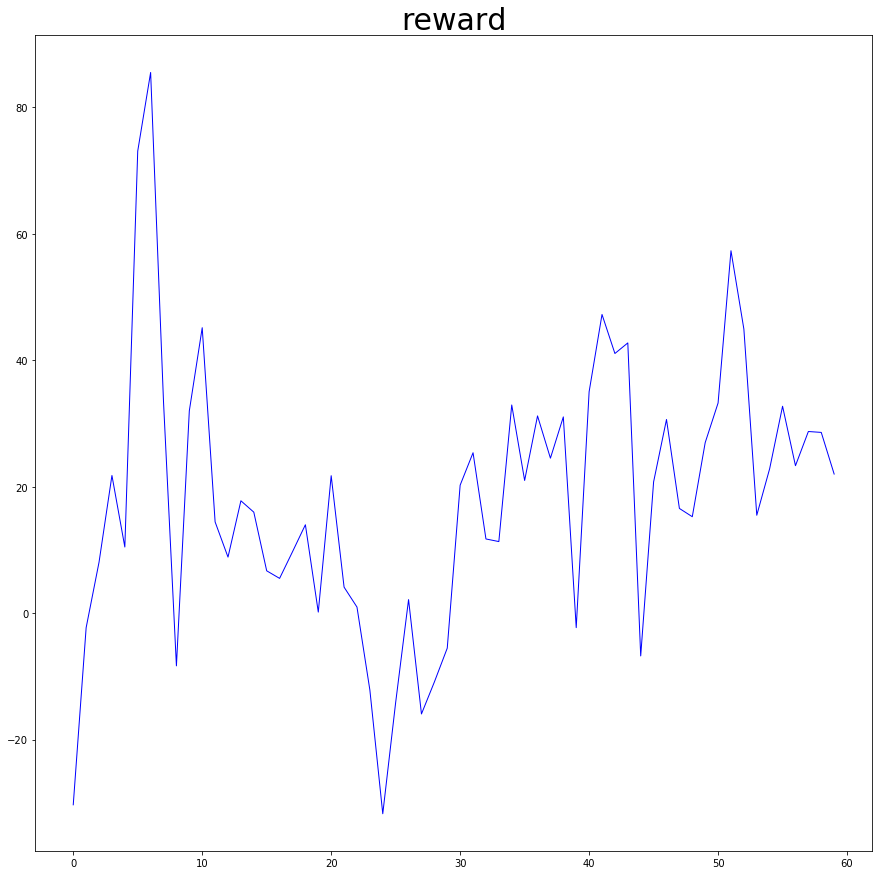

Parameter containing:
tensor([-3.8039e-01,  2.6129e-02, -3.0395e-01, -7.0466e-04, -1.4103e+00,
        -5.8889e-03], requires_grad=True)
[18.596634]
[62.596104]
tensor(-299.1491, grad_fn=<AddBackward0>)
mean_average : [ 0.79729154 -0.88845851  0.74448894  0.27958895  0.87853621  0.31264165]
variance_average : [0.40764192 0.20532133 0.38672474 0.46417315 0.10829722 0.56634515]
training idx 1 actor true_reward at iteration 70 : 46.47554090324433
44630
Parameter containing:
tensor([-0.5511, -0.1643, -0.4499, -0.0630, -1.5059, -0.1152],
       requires_grad=True)
[-1.735508]
[35.53956]
tensor(-15.0260, grad_fn=<AddBackward0>)
mean_average : [ 0.60016797 -0.85110284  0.84252605  0.05228457  0.64057553  0.10053841]
variance_average : [0.29845166 0.14332352 0.29080191 0.42113579 0.08891442 0.47824234]
training idx 1 actor true_reward at iteration 80 : 3.0173811224728664
54630
Parameter containing:
tensor([-0.6893, -0.2796, -0.5009, -0.1430, -1.5391, -0.1553],
       requires_grad=True)
[-10.3

Parameter containing:
tensor([-1.1178, -0.9128, -0.9582, -0.6351, -2.1910, -0.7577],
       requires_grad=True)
[4.323374]
[10.592361]
tensor(30.8080, grad_fn=<AddBackward0>)
mean_average : [ 0.83806191  0.80727652 -0.71611885 -0.77182952 -0.88396416  0.94063746]
variance_average : [0.22687171 0.24269853 0.24706273 0.3159     0.24035087 0.19601014]
training idx 1 actor true_reward at iteration 270 : 3.9935869139618356
78095
Parameter containing:
tensor([-1.1034, -0.8940, -0.9460, -0.6159, -2.1790, -0.7409],
       requires_grad=True)
[23.98696]
[9.664177]
tensor(24.0267, grad_fn=<AddBackward0>)
mean_average : [ 0.81721329  0.78638089 -0.41121017 -0.52290141 -0.5140852   0.78684821]
variance_average : [0.14557753 0.16791787 0.16565814 0.23361818 0.10753461 0.22159839]
training idx 1 actor true_reward at iteration 280 : -3.633765958745236
78358
Parameter containing:
tensor([-1.0943, -0.8878, -0.9351, -0.6076, -2.1710, -0.7383],
       requires_grad=True)
[-13.656774]
[9.433525]
tensor(16

Parameter containing:
tensor([-1.1498, -0.9606, -0.9504, -0.7276, -2.2400, -0.7542],
       requires_grad=True)
[8.818794]
[5.347785]
tensor(21.5877, grad_fn=<AddBackward0>)
mean_average : [ 7.51240660e-01  8.01817574e-01 -1.92145485e-01  8.01768806e-01
 -3.85393699e-05 -7.16457888e-01]
variance_average : [0.21385836 0.10505706 0.25667422 0.30580767 0.09365587 0.31673472]
training idx 1 actor true_reward at iteration 470 : 2.724288096891758
83205
Parameter containing:
tensor([-1.1573, -0.9685, -0.9540, -0.7361, -2.2527, -0.7657],
       requires_grad=True)
[1.6375194]
[3.3940601]
tensor(20.3146, grad_fn=<AddBackward0>)
mean_average : [ 0.7001063   0.79221093  0.05811736  0.88839796  0.07810278 -0.72277436]
variance_average : [0.14777662 0.25880755 0.33666136 0.16912096 0.12788174 0.37869233]
training idx 1 actor true_reward at iteration 480 : 7.839189102592942
83443
Parameter containing:
tensor([-1.1574, -0.9713, -0.9517, -0.7427, -2.2621, -0.7689],
       requires_grad=True)
[-54.1642

Parameter containing:
tensor([-1.0730, -0.9128, -0.9467, -0.6672, -2.1907, -0.7386],
       requires_grad=True)
[99.15479]
[41.233383]
tensor(59.0858, grad_fn=<AddBackward0>)
mean_average : [ 0.88090782  0.89473081 -0.15573226  0.88495632 -0.53303539 -0.90296649]
variance_average : [0.13374871 0.07601206 0.18194835 0.16913431 0.06494432 0.20828512]
training idx 1 actor true_reward at iteration 670 : -9.552772168672822
89026
Parameter containing:
tensor([-1.0640, -0.9116, -0.9402, -0.6558, -2.1786, -0.7322],
       requires_grad=True)
[2.047759]
[2.7007947]
tensor(11.4313, grad_fn=<AddBackward0>)
mean_average : [ 0.68333838  0.67782062 -0.39321742  0.6854196  -0.21265106 -0.68716628]
variance_average : [0.23237079 0.39467143 0.47396637 0.42881049 0.10664403 0.26326085]
training idx 1 actor true_reward at iteration 680 : 2.402930466395107
89232
Parameter containing:
tensor([-1.0612, -0.9229, -0.9492, -0.6595, -2.1884, -0.7305],
       requires_grad=True)
[-55.879967]
[19.323528]
tensor(5

Parameter containing:
tensor([-0.5976, -0.4975, -0.4819, -0.1718, -1.7197, -0.3045],
       requires_grad=True)
[-61.088203]
[36.703865]
tensor(90.4586, grad_fn=<AddBackward0>)
mean_average : [-0.85648543  0.07275492  0.20231461  0.9781441   0.42257032 -0.00401736]
variance_average : [0.29625766 0.07694901 0.30028524 0.35545944 0.08365635 0.35183873]
training idx 1 actor true_reward at iteration 870 : 36.95609690854798
109626
Parameter containing:
tensor([-0.6348, -0.5277, -0.5452, -0.2228, -1.7648, -0.3649],
       requires_grad=True)
[-10.507615]
[20.863165]
tensor(22.3035, grad_fn=<AddBackward0>)
mean_average : [-0.10159763 -0.09909457  0.58073067  0.94673107  0.59619198 -0.04253917]
variance_average : [0.28173749 0.14191312 0.27229261 0.35600623 0.11298873 0.35489435]
training idx 1 actor true_reward at iteration 880 : -3.2230445885350654
110880
Parameter containing:
tensor([-0.6139, -0.4968, -0.5250, -0.2053, -1.7491, -0.3309],
       requires_grad=True)
[-0.29231218]
[39.83166]
t

Parameter containing:
tensor([-0.9997, -1.0215, -1.0232, -0.5926, -2.1186, -0.7536],
       requires_grad=True)
[-34.132492]
[6.298138]
tensor(79.4268, grad_fn=<AddBackward0>)
mean_average : [ 0.3941619  -0.68614     0.78920472  0.92521835  0.93843824  0.73512273]
variance_average : [0.19746547 0.0688962  0.12873278 0.19073857 0.09170752 0.18983122]
training idx 1 actor true_reward at iteration 1070 : 26.936253041215576
152560
Parameter containing:
tensor([-1.0328, -1.0773, -1.0824, -0.6625, -2.1611, -0.8185],
       requires_grad=True)
[-180.7346]
[64.640564]
tensor(84.4038, grad_fn=<AddBackward0>)
mean_average : [ 0.46737753 -0.30730216  0.83066336  0.93017492  0.94463619  0.56744895]
variance_average : [0.16777907 0.07891625 0.10698566 0.16673526 0.07844671 0.19093956]
training idx 1 actor true_reward at iteration 1080 : 53.690993534820656
153267
Parameter containing:
tensor([-1.0901, -1.1105, -1.1416, -0.7412, -2.2170, -0.8859],
       requires_grad=True)
[-157.97192]
[40.938305]
t

Parameter containing:
tensor([-2.0606, -2.1076, -2.1627, -1.7739, -3.2561, -1.9375],
       requires_grad=True)
[-190.71265]
[37.05776]
tensor(284.4677, grad_fn=<AddBackward0>)
mean_average : [ 0.15180829  0.01970234  0.93664451  0.92526127  0.96637884 -0.11467496]
variance_average : [0.02683883 0.09015778 0.03547935 0.08386965 0.0482011  0.08847347]
training idx 1 actor true_reward at iteration 1260 : 35.96215646178161
167235
Parameter containing:
tensor([-2.1159, -2.1591, -2.2309, -1.8522, -3.3199, -2.0080],
       requires_grad=True)
[-510.32803]
[72.19861]
tensor(349.6617, grad_fn=<AddBackward0>)
mean_average : [-0.06982966  0.01169118  0.92300363  0.93785125  0.956848   -0.11656195]
variance_average : [0.03190305 0.08325724 0.01849028 0.04705519 0.04156103 0.05421397]
training idx 1 actor true_reward at iteration 1270 : 60.33564283834058
168044
Parameter containing:
tensor([-2.1482, -2.1925, -2.2787, -1.8954, -3.3301, -2.0430],
       requires_grad=True)
[-58.907375]
[27.391415]
t

Parameter containing:
tensor([-2.9912, -2.9969, -3.1191, -2.7524, -4.1893, -2.9214],
       requires_grad=True)
[-429.46942]
[43.203957]
tensor(481.1483, grad_fn=<AddBackward0>)
mean_average : [ 0.27731289 -0.28342827  0.92935206  0.94695425  0.9406302   0.22990466]
variance_average : [0.03527525 0.01890061 0.01741951 0.07761125 0.04019619 0.03670125]
training idx 1 actor true_reward at iteration 1450 : 49.39080354802566
181545
Parameter containing:
tensor([-3.0220, -3.0230, -3.1484, -2.7725, -4.2283, -2.9419],
       requires_grad=True)
[-1349.0933]
[167.08998]
tensor(425.2323, grad_fn=<AddBackward0>)
mean_average : [ 0.36113024 -0.42359512  0.94610922  0.90692555  0.91387551  0.11425107]
variance_average : [0.06309099 0.06566807 0.0893537  0.08315401 0.08546001 0.05181623]
training idx 1 actor true_reward at iteration 1460 : 72.88707959732471
182218
Parameter containing:
tensor([-3.0862, -3.0950, -3.2233, -2.8538, -4.2923, -3.0259],
       requires_grad=True)
[-1304.185]
[132.88245]


Parameter containing:
tensor([-3.7318, -3.6371, -3.8836, -3.5364, -4.8561, -3.7235],
       requires_grad=True)
[-292.6057]
[12.248863]
tensor(359.1254, grad_fn=<AddBackward0>)
mean_average : [ 0.32580261 -0.03274204  0.91290902  0.86678347  0.96124483 -0.09363436]
variance_average : [0.07299945 0.04446769 0.0358573  0.07197778 0.03411068 0.02272595]
training idx 1 actor true_reward at iteration 1640 : 34.60474483959316
195955
Parameter containing:
tensor([-3.7630, -3.6766, -3.9125, -3.5623, -4.8876, -3.7539],
       requires_grad=True)
[116.23813]
[11.722885]
tensor(356.8069, grad_fn=<AddBackward0>)
mean_average : [ 0.52511916 -0.02200185  0.89273555  0.89782931  0.89208542 -0.14161058]
variance_average : [0.03331566 0.12005147 0.06603611 0.13313454 0.09796351 0.12966883]
training idx 1 actor true_reward at iteration 1650 : 18.80323446040337
196615
Parameter containing:
tensor([-3.8179, -3.7053, -3.9554, -3.6238, -4.9300, -3.7921],
       requires_grad=True)
[-667.44617]
[35.95799]
te

Parameter containing:
tensor([-4.6008, -4.3185, -4.6709, -4.4115, -5.5250, -4.5667],
       requires_grad=True)
[-594.7101]
[28.722557]
tensor(554.6840, grad_fn=<AddBackward0>)
mean_average : [ 0.0278809   0.16113187  0.91256113  0.92326817  0.93198385 -0.01137404]
variance_average : [0.07057072 0.02905189 0.07959384 0.02982702 0.04391573 0.05068494]
training idx 1 actor true_reward at iteration 1830 : 47.31266623462425
209971
Parameter containing:
tensor([-4.6473, -4.3518, -4.7051, -4.4482, -5.5610, -4.6037],
       requires_grad=True)
[-1959.6967]
[142.47014]
tensor(712.2760, grad_fn=<AddBackward0>)
mean_average : [-0.00659506  0.01339958  0.93828724  0.94600003  0.94437478 -0.01501035]
variance_average : [0.01198002 0.03318881 0.02446619 0.03039054 0.01271089 0.01680256]
training idx 1 actor true_reward at iteration 1840 : 98.19020536909026
210685
Parameter containing:
tensor([-4.6962, -4.3886, -4.7396, -4.4947, -5.5970, -4.6396],
       requires_grad=True)
[-365.5966]
[27.606895]
t

Parameter containing:
tensor([-5.0738, -4.6467, -5.0573, -4.8639, -5.8482, -4.9962],
       requires_grad=True)
[470.84558]
[19.5221]
tensor(648.7816, grad_fn=<AddBackward0>)
mean_average : [ 0.01526804  0.04976205 -0.93179688  0.94428051  0.92215286  0.0096568 ]
variance_average : [0.03752713 0.06778697 0.04429723 0.02799145 0.02048699 0.01153299]
training idx 1 actor true_reward at iteration 2020 : -2.0418784345817595
225228
Parameter containing:
tensor([-5.0670, -4.6339, -5.0554, -4.8551, -5.8406, -4.9851],
       requires_grad=True)
[-15.6204605]
[14.1988125]
tensor(455.6952, grad_fn=<AddBackward0>)
mean_average : [ 0.05636508 -0.03650263 -0.92377754  0.93383747  0.93488667 -0.04869874]
variance_average : [0.06398556 0.05247919 0.05949705 0.04246959 0.05627847 0.02549142]
training idx 1 actor true_reward at iteration 2030 : 14.659758067771167
226021
Parameter containing:
tensor([-5.0615, -4.6132, -5.0565, -4.8483, -5.8196, -4.9829],
       requires_grad=True)
[-161.11734]
[12.87329

Parameter containing:
tensor([-5.0903, -4.4954, -5.0801, -4.7862, -5.7403, -4.9144],
       requires_grad=True)
[-382.06314]
[12.244175]
tensor(680.7678, grad_fn=<AddBackward0>)
mean_average : [ 0.02108325  0.01568931 -0.95267733  0.95113988  0.95761285  0.00752551]
variance_average : [0.03884395 0.01158761 0.02164254 0.01650448 0.04954696 0.02124133]
training idx 1 actor true_reward at iteration 2210 : 27.398484078365346
242265
Parameter containing:
tensor([-5.0799, -4.4693, -5.0605, -4.7693, -5.7242, -4.9114],
       requires_grad=True)
[-33.16279]
[7.3800035]
tensor(548.2946, grad_fn=<AddBackward0>)
mean_average : [ 0.09944515 -0.0208171  -0.92924109  0.91411132  0.92552944  0.01347742]
variance_average : [0.02222696 0.0400305  0.0130165  0.05156229 0.09295827 0.05766733]
training idx 1 actor true_reward at iteration 2220 : 14.12589918385756
243118
Parameter containing:
tensor([-5.0865, -4.4807, -5.0703, -4.7690, -5.7231, -4.9136],
       requires_grad=True)
[347.20935]
[31.991161]


Parameter containing:
tensor([-5.2724, -4.6753, -5.2402, -5.0466, -5.8439, -5.0854],
       requires_grad=True)
[-477.4637]
[13.824074]
tensor(432.7108, grad_fn=<AddBackward0>)
mean_average : [ 0.35582036 -0.21863663 -0.92887981  0.9287544   0.91745033  0.18077024]
variance_average : [0.03642472 0.05228906 0.02207422 0.10169163 0.06779453 0.05126548]
training idx 1 actor true_reward at iteration 2400 : 26.832636539741795
259300
Parameter containing:
tensor([-5.3189, -4.7180, -5.2943, -5.0892, -5.8714, -5.1250],
       requires_grad=True)
[-344.35092]
[15.626716]
tensor(399.3129, grad_fn=<AddBackward0>)
mean_average : [ 0.63104086 -0.45704491 -0.9270962   0.93754077  0.8861449   0.38798808]
variance_average : [0.15445425 0.09820115 0.05077391 0.1515336  0.07872811 0.03363851]
training idx 1 actor true_reward at iteration 2410 : 23.08930882578425
260005
Parameter containing:
tensor([-5.3230, -4.7298, -5.3192, -5.1016, -5.8727, -5.1341],
       requires_grad=True)
[-41.64758]
[41.41681]
t

Parameter containing:
tensor([-5.7538, -5.1154, -5.7395, -5.5235, -6.1770, -5.6698],
       requires_grad=True)
[-306.25656]
[8.681903]
tensor(603.4141, grad_fn=<AddBackward0>)
mean_average : [ 0.94646517 -0.94609538 -0.95362168  0.94398827  0.9494574   0.9354437 ]
variance_average : [0.02615869 0.0299415  0.02081342 0.05365959 0.0133049  0.04470475]
training idx 1 actor true_reward at iteration 2590 : 34.22039631197272
287038
Parameter containing:
tensor([-5.7865, -5.1274, -5.7451, -5.5443, -6.1743, -5.6978],
       requires_grad=True)
[85.20598]
[24.329966]
tensor(983.4068, grad_fn=<AddBackward0>)
mean_average : [ 0.96509087 -0.96690414 -0.96800799  0.96864511  0.95822848  0.98606525]
variance_average : [0.0226059  0.04967105 0.04752937 0.05894682 0.06316806 0.01385788]
training idx 1 actor true_reward at iteration 2600 : 23.438487460751478
288329
Parameter containing:
tensor([-5.7809, -5.1408, -5.7678, -5.5745, -6.2009, -5.7131],
       requires_grad=True)
[-310.42126]
[16.766966]
t

Parameter containing:
tensor([-5.7880, -5.1358, -5.7617, -5.6256, -6.2283, -5.7519],
       requires_grad=True)
[-890.6235]
[37.39147]
tensor(978.7609, grad_fn=<AddBackward0>)
mean_average : [ 0.96604865 -0.96258267 -0.94292957  0.95267921  0.96360784  0.98838811]
variance_average : [0.02348981 0.02877501 0.0512738  0.00987072 0.00632367 0.06467786]
training idx 1 actor true_reward at iteration 2780 : 50.532635359486726
312881
Parameter containing:
tensor([-5.8251, -5.1631, -5.7934, -5.6554, -6.2549, -5.7826],
       requires_grad=True)
[152.87787]
[18.794764]
tensor(346.5224, grad_fn=<AddBackward0>)
mean_average : [ 0.93019412 -0.93903482 -0.93680414  0.87936673  0.87782884  0.87139924]
variance_average : [0.07388502 0.05349442 0.07239085 0.05988887 0.10672971 0.12968773]
training idx 1 actor true_reward at iteration 2790 : 18.272665653292673
314084
Parameter containing:
tensor([-5.8334, -5.1621, -5.8174, -5.6666, -6.3014, -5.8030],
       requires_grad=True)
[-390.57666]
[15.679015]


Parameter containing:
tensor([-6.0989, -5.3543, -6.0831, -5.8416, -6.4373, -5.9275],
       requires_grad=True)
[-581.19244]
[13.561215]
tensor(649.3105, grad_fn=<AddBackward0>)
mean_average : [ 0.94748046 -0.96550308 -0.93241457  0.94514127  0.94023369  0.924383  ]
variance_average : [0.04246414 0.02826388 0.0809856  0.02560371 0.01215358 0.01447431]
training idx 1 actor true_reward at iteration 2970 : 37.85368746632919
344418
Parameter containing:
tensor([-6.0860, -5.3724, -6.0823, -5.8709, -6.4622, -5.9433],
       requires_grad=True)
[-763.0381]
[23.998081]
tensor(964.6008, grad_fn=<AddBackward0>)
mean_average : [ 0.97935334 -0.95509731 -0.96016084  0.95327784  0.9756385   0.95531811]
variance_average : [0.01050936 0.03779031 0.02833408 0.01575117 0.01539634 0.01654179]
training idx 1 actor true_reward at iteration 2980 : 45.71122466122152
345550
Parameter containing:
tensor([-6.0802, -5.3923, -6.1017, -5.8659, -6.4844, -5.9826],
       requires_grad=True)
[-560.26483]
[35.798843]


Parameter containing:
tensor([-5.9837, -5.3928, -6.1277, -5.7805, -6.3176, -5.8444],
       requires_grad=True)
[3937.7139]
[158.4957]
tensor(7643.9580, grad_fn=<AddBackward0>)
mean_average : [ 0.99538171 -0.99555752 -0.99546746  0.99582478  0.99713363  0.99371389]
variance_average : [0.00374243 0.00433839 0.00413407 0.00675336 0.00359789 0.00231967]
training idx 1 actor true_reward at iteration 3160 : 11.079872145392434
375551
Parameter containing:
tensor([-5.9748, -5.3701, -6.1209, -5.7694, -6.3158, -5.8586],
       requires_grad=True)
[-635.5018]
[17.968906]
tensor(1069.8866, grad_fn=<AddBackward0>)
mean_average : [ 0.95240159 -0.98796541 -0.98983693  0.97635006  0.96181451  0.9515179 ]
variance_average : [0.02586114 0.01634005 0.0404923  0.05302156 0.00784656 0.03652043]
training idx 1 actor true_reward at iteration 3170 : 43.753893143430396
378306
Parameter containing:
tensor([-5.9803, -5.4337, -6.1578, -5.8090, -6.3661, -5.9163],
       requires_grad=True)
[-358.16364]
[12.940424

Parameter containing:
tensor([-6.1768, -5.4479, -6.2288, -5.8611, -6.5537, -6.0811],
       requires_grad=True)
[-717.64233]
[15.459406]
tensor(1001.3187, grad_fn=<AddBackward0>)
mean_average : [ 0.96322977 -0.96876354 -0.96735251  0.96542862  0.95653281  0.9633065 ]
variance_average : [0.06122724 0.01538939 0.02032272 0.01081506 0.02887621 0.03375272]
training idx 1 actor true_reward at iteration 3350 : 49.52157179705609
408815
Parameter containing:
tensor([-6.1860, -5.4545, -6.2410, -5.8626, -6.5688, -6.1017],
       requires_grad=True)
[-749.96564]
[25.319084]
tensor(638.4199, grad_fn=<AddBackward0>)
mean_average : [ 0.93613446 -0.9654222  -0.93960411  0.94353929  0.96647801  0.91455692]
variance_average : [0.01865059 0.09199262 0.06755334 0.03337281 0.05631888 0.05217839]
training idx 1 actor true_reward at iteration 3360 : 52.84139824852251
410011
Parameter containing:
tensor([-6.1640, -5.4761, -6.2390, -5.8712, -6.5634, -6.1298],
       requires_grad=True)
[-220.49307]
[5.301588]

Parameter containing:
tensor([-6.1875, -5.5724, -6.2698, -5.9278, -6.5555, -6.1202],
       requires_grad=True)
[-963.60944]
[37.75371]
tensor(1110.6929, grad_fn=<AddBackward0>)
mean_average : [ 0.96490243 -0.9557828  -0.97207661  0.96609338  0.96012613  0.95294962]
variance_average : [0.00601105 0.01827609 0.01617044 0.02951736 0.0333088  0.01162255]
training idx 1 actor true_reward at iteration 3540 : 54.05651413438803
436239
Parameter containing:
tensor([-6.1963, -5.5906, -6.2721, -5.9178, -6.5358, -6.1266],
       requires_grad=True)
[-567.9309]
[25.898542]
tensor(1829.9631, grad_fn=<AddBackward0>)
mean_average : [ 0.98057142 -0.97846343 -0.97808464  0.97145867  0.97733055  0.97940683]
variance_average : [0.03163143 0.01137208 0.01174866 0.01507745 0.01937378 0.02989921]
training idx 1 actor true_reward at iteration 3550 : 44.17024005297141
438942
Parameter containing:
tensor([-6.1887, -5.5850, -6.2357, -5.8715, -6.5103, -6.1012],
       requires_grad=True)
[-385.7056]
[7.961425]
t

Parameter containing:
tensor([-6.0990, -5.4844, -6.1437, -5.7770, -6.4436, -5.9980],
       requires_grad=True)
[-62.663803]
[11.327857]
tensor(447.9799, grad_fn=<AddBackward0>)
mean_average : [ 0.90915961 -0.18495444 -0.9245498   0.93783933  0.93978559  0.93696627]
variance_average : [0.06330312 0.05644116 0.02098617 0.0655449  0.06739722 0.04127021]
training idx 1 actor true_reward at iteration 3730 : 14.865390383106783
450936
Parameter containing:
tensor([-6.0793, -5.4819, -6.1292, -5.7693, -6.4503, -5.9918],
       requires_grad=True)
[-191.67915]
[7.9401393]
tensor(270.3373, grad_fn=<AddBackward0>)
mean_average : [ 0.90562383  0.16781814 -0.86844231  0.90500036  0.91780481  0.89072067]
variance_average : [0.13519376 0.05609883 0.07990042 0.0387899  0.15533966 0.11847054]
training idx 1 actor true_reward at iteration 3740 : 20.092390350213325
451332
Parameter containing:
tensor([-6.0661, -5.4749, -6.1061, -5.7507, -6.4244, -5.9731],
       requires_grad=True)
[-649.7012]
[38.478527

Parameter containing:
tensor([-6.0166, -5.3937, -6.0058, -5.6725, -6.3678, -5.8375],
       requires_grad=True)
[-179.72531]
[10.896787]
tensor(242.9126, grad_fn=<AddBackward0>)
mean_average : [ 0.83926902  0.19551884 -0.87548951  0.88889956  0.8123169   0.80950858]
variance_average : [0.05427954 0.0571466  0.07928624 0.04409076 0.02946681 0.08980039]
training idx 1 actor true_reward at iteration 3920 : 16.313499205201897
457986
Parameter containing:
tensor([-5.9991, -5.3943, -6.0026, -5.6601, -6.3681, -5.8326],
       requires_grad=True)
[54.541]
[1.719204]
tensor(85.0611, grad_fn=<AddBackward0>)
mean_average : [ 0.69504264 -0.1942999  -0.69892416  0.69430379  0.62198147  0.62764233]
variance_average : [0.36744291 0.37597042 0.05713822 0.40349044 0.29224682 0.18944146]
training idx 1 actor true_reward at iteration 3930 : 12.543391449578989
458412
Parameter containing:
tensor([-5.9914, -5.3763, -5.9936, -5.6647, -6.3668, -5.8201],
       requires_grad=True)
[-96.88356]
[3.8762019]
tens

Parameter containing:
tensor([-5.8838, -5.3047, -5.9617, -5.6246, -6.3553, -5.7982],
       requires_grad=True)
[-385.32953]
[18.320524]
tensor(356.2577, grad_fn=<AddBackward0>)
mean_average : [ 0.93536651 -0.34673128 -0.89397616  0.86751087  0.92485147  0.92474402]
variance_average : [0.06478959 0.08200193 0.063294   0.0467479  0.11436981 0.01526247]
training idx 1 actor true_reward at iteration 4110 : 23.071219259086433
465263
Parameter containing:
tensor([-5.9047, -5.2875, -5.9629, -5.6322, -6.3675, -5.7917],
       requires_grad=True)
[17.573944]
[16.792892]
tensor(539.1085, grad_fn=<AddBackward0>)
mean_average : [ 0.95546302 -0.52791034 -0.93786084  0.92348898  0.93093355  0.87777036]
variance_average : [0.06174781 0.11185222 0.06819021 0.01319892 0.04741425 0.05201355]
training idx 1 actor true_reward at iteration 4120 : 8.983717092710377
465756
Parameter containing:
tensor([-5.9013, -5.2673, -5.9671, -5.6179, -6.3715, -5.7824],
       requires_grad=True)
[-297.46783]
[9.441059]


Parameter containing:
tensor([-5.8449, -5.2113, -5.9547, -5.6064, -6.3888, -5.7921],
       requires_grad=True)
[38.497288]
[4.54392]
tensor(262.7063, grad_fn=<AddBackward0>)
mean_average : [ 0.87453148 -0.12616875 -0.8780906   0.85233548  0.89060319  0.8667118 ]
variance_average : [0.15084036 0.14326742 0.08479356 0.08210361 0.07763962 0.04050988]
training idx 1 actor true_reward at iteration 4300 : 14.019251570044718
472811
Parameter containing:
tensor([-5.8390, -5.2069, -5.9559, -5.6077, -6.3824, -5.7937],
       requires_grad=True)
[299.44305]
[10.999596]
tensor(216.6110, grad_fn=<AddBackward0>)
mean_average : [ 0.82570767 -0.03873567 -0.84072846  0.84077811  0.83585479  0.84454575]
variance_average : [0.24341916 0.11903566 0.17488534 0.04944146 0.0490222  0.09801905]
training idx 1 actor true_reward at iteration 4310 : 8.27825226583528
473277
Parameter containing:
tensor([-5.8639, -5.2088, -5.9618, -5.6098, -6.3802, -5.8038],
       requires_grad=True)
[-185.32816]
[9.549185]
tens

Parameter containing:
tensor([-5.7639, -5.1362, -5.8757, -5.5747, -6.2566, -5.7871],
       requires_grad=True)
[-327.32867]
[12.966717]
tensor(403.8041, grad_fn=<AddBackward0>)
mean_average : [ 0.89996868 -0.18810578 -0.90799577  0.89493768  0.88508447  0.88674144]
variance_average : [0.02624499 0.0250471  0.07889471 0.05537874 0.04142736 0.02931296]
training idx 1 actor true_reward at iteration 4500 : 24.60927211219906
480939
Parameter containing:
tensor([-5.7599, -5.1286, -5.8790, -5.5693, -6.2459, -5.7914],
       requires_grad=True)
[-11.621117]
[6.8756576]
tensor(224.7539, grad_fn=<AddBackward0>)
mean_average : [ 0.80786307  0.61879321 -0.83349135  0.79704364  0.85692984  0.85077139]
variance_average : [0.02506063 0.1259294  0.14787945 0.06446394 0.22010938 0.09722955]
training idx 1 actor true_reward at iteration 4510 : 12.40539087670023
481337
Parameter containing:
tensor([-5.7532, -5.1259, -5.8698, -5.5628, -6.2365, -5.7851],
       requires_grad=True)
[78.71414]
[3.970493]
te

Parameter containing:
tensor([-5.7045, -5.0716, -5.8406, -5.5906, -6.1668, -5.7634],
       requires_grad=True)
[-76.70998]
[12.127002]
tensor(307.5753, grad_fn=<AddBackward0>)
mean_average : [ 0.86497179 -0.32548474 -0.897964    0.90471208  0.87478528  0.92021911]
variance_average : [0.10771599 0.05684291 0.13815709 0.0459976  0.09763953 0.19111457]
training idx 1 actor true_reward at iteration 4690 : 22.57330029167596
488110
Parameter containing:
tensor([-5.7038, -5.0614, -5.8396, -5.5982, -6.1658, -5.7660],
       requires_grad=True)
[-52.46454]
[1.4832892]
tensor(257.5648, grad_fn=<AddBackward0>)
mean_average : [ 0.87411904 -0.05164402 -0.86900815  0.85321421  0.86854094  0.88145222]
variance_average : [0.02543064 0.06519054 0.03158626 0.17771107 0.07863284 0.0591745 ]
training idx 1 actor true_reward at iteration 4700 : 17.181444061133156
488474
Parameter containing:
tensor([-5.7070, -5.0630, -5.8344, -5.6003, -6.1529, -5.7683],
       requires_grad=True)
[220.46802]
[8.141012]
te

Parameter containing:
tensor([-5.8054, -5.1070, -5.8376, -5.6680, -6.2078, -5.7737],
       requires_grad=True)
[4.269421]
[5.424818]
tensor(361.9420, grad_fn=<AddBackward0>)
mean_average : [ 0.90292845 -0.6829968  -0.91561668  0.90316314  0.91840904  0.92754685]
variance_average : [0.07941017 0.04216459 0.07777896 0.10064991 0.08340538 0.08269762]
training idx 1 actor true_reward at iteration 4880 : 24.846236178666537
502499
Parameter containing:
tensor([-5.8028, -5.1038, -5.8400, -5.6733, -6.2090, -5.7591],
       requires_grad=True)
[-256.54538]
[12.65002]
tensor(224.0631, grad_fn=<AddBackward0>)
mean_average : [ 0.80576627 -0.07352181 -0.80037518  0.76975721  0.84127058  0.80365983]
variance_average : [0.04626981 0.12696284 0.21627768 0.1122829  0.065104   0.13806126]
training idx 1 actor true_reward at iteration 4890 : 25.370207899348127
503265
Parameter containing:
tensor([-5.7781, -5.0797, -5.8308, -5.6834, -6.2134, -5.7478],
       requires_grad=True)
[114.50564]
[9.168663]
ten

In [8]:
reward_np = np.array(reward_plot[:60])  
fig, axe = plt.subplots(1, figsize = (15,15))
axe.plot(list(range(len(reward_np))),reward_np, lw = 1, label = 'reward', color = 'blue')
axe.set_title('reward', fontsize = 30)


In [10]:
#test
state = []
done = False
reward_sum=0
env = gym.make('DobroHalfCheetah-v0')
env.unwrapped.initialize(is_render=True)

observation = env.reset()

state = observation

for t in range(10000):
    env.render()
    
    mean, variance= p_net_shared(torch.Tensor(state))
    value = v_net_shared(torch.Tensor(state))

    action = get_action(mean,variance,num_actions)
    
    obs , reward, done, info = env.step(action)
    
    
    reward_sum = reward_sum + reward
    state=obs
    if done:
        break
    
print("reward {}".format(reward_sum))

reward 31.45974749084725


In [ ]:
action = [np.random.normal(mean[i].detach(), variance[i].detach(), 1).item() for i in range(num_actions) ]
    true_action = []
    for i in range(len(mean)):
        if(action[i]<-1):
            true_action.append(-1)
        elif(action[i]>1):
            true_action.append(1)
        else:
            true_action.append(action[i])
    return true_action